# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
%matplotlib notebook

### Rozwiązanie

<IPython.core.display.Javascript object>


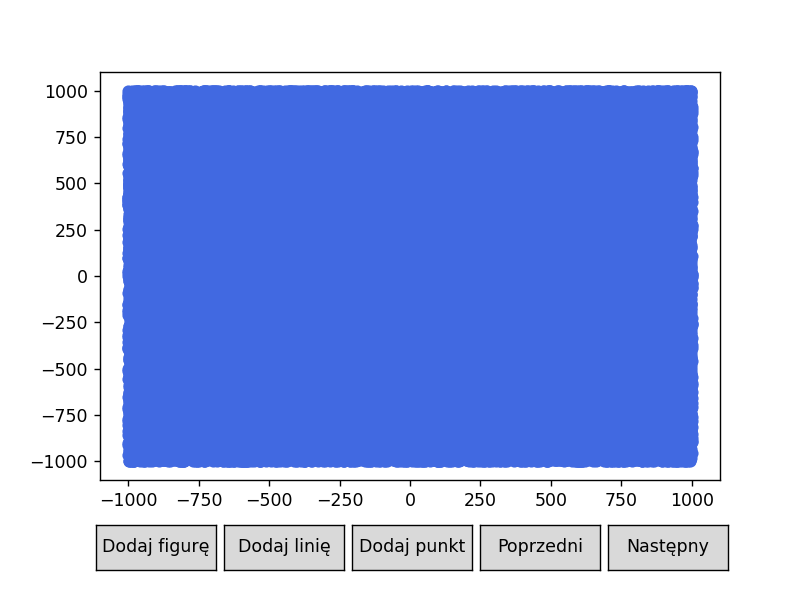

In [4]:
# Generowanie zbiorów:

from random import uniform


T1 = [(uniform(-1000,1000), uniform(-1000,1000)) for _ in range(10**5)]

plot = Plot(points=[PointsCollection(T1, color = 'royalblue')])
plot.draw()

<IPython.core.display.Javascript object>


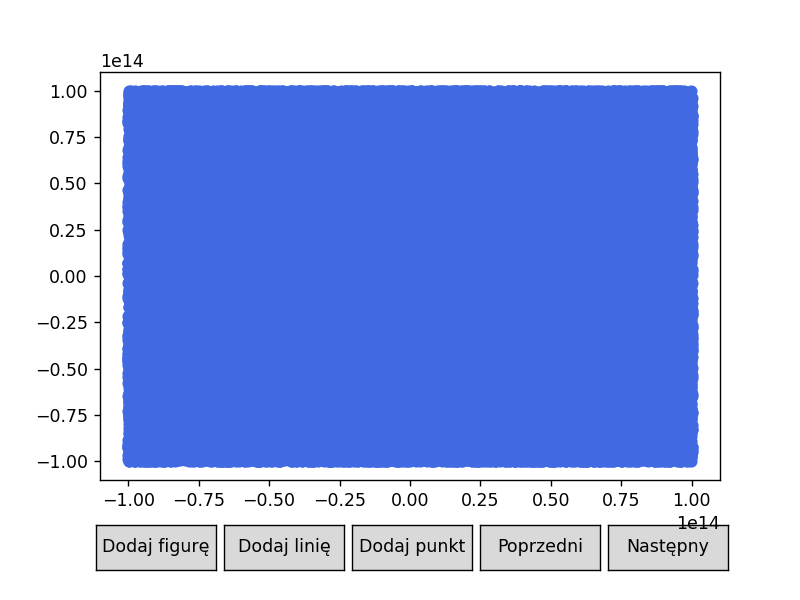

In [5]:
T2 = [(uniform(-10**14,10**14), uniform(-10**14,10**14)) for _ in range(10**5)]

plot = Plot(points=[PointsCollection(T2, color = 'royalblue')])
plot.draw()

<IPython.core.display.Javascript object>


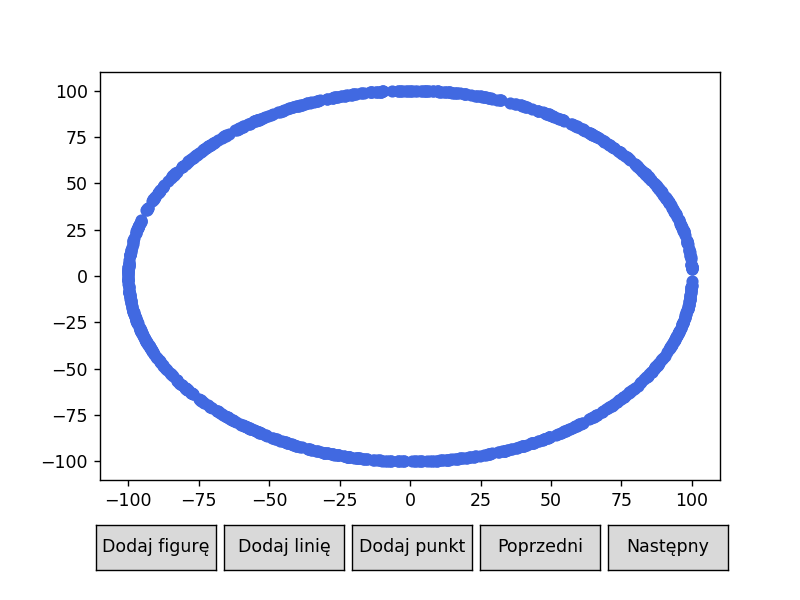

In [6]:
from math import pi
from math import sin
from math import cos

circle = [(0.0, 0.0) for _ in range(1000)]
for i in range(1000):
    alfa = uniform(0, 2 * pi)
    circle[i] = (100 * cos(alfa), 100 * sin(alfa))
    
plot = Plot(points=[PointsCollection(circle, color = 'royalblue')])
plot.draw()

<IPython.core.display.Javascript object>


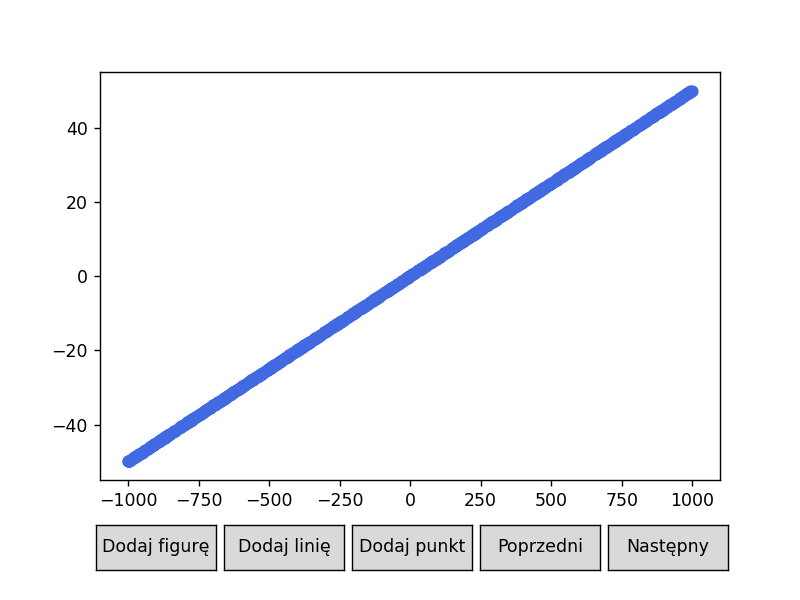

In [7]:
line = [(0.0, 0.0) for _ in range(1000)]
for i in range(1000):
    x = uniform(-1000, 1000)
    line[i] = (x, 0.05 * x + 0.05)
    
plot = Plot(points=[PointsCollection(line, color = 'royalblue')])
plot.draw()

In [8]:
#Obliczanie wyznaczników:

def det1(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0]*c[1] - (b[1] * c[0] + a[0] * c[1] + a[1] * b[0])

In [9]:
def det2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

In [10]:
import numpy as np

def det3(a, b, c):
    M = [[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]]
    
    return np.linalg.det(M)

In [11]:
import numpy as np

def det4(a, b, c):
    M = [[a[0] - c[0], a[1] - c[1]], [b[0] - c[0], b[1] - c[1]]]
    
    return np.linalg.det(M)

In [12]:
# Grupowanie punktów:
def group(T, det, tol):
    left = []
    right = []
    mid = []
    
    for p in T:
        if det((-1.0, 0.0), (1.0, 0.1), p) < -tol:
            right.append(p)
        elif det((-1.0, 0.0), (1.0, 0.1), p) > tol:
            left.append(p)
        else:
            mid.append(p)
            
    
    return left, mid, right

In [13]:
# Rysowanie grafu:
def draw_graph(T, det, tol):
    l, m, r = group(T, det, tol)
    plot = Plot(points=[PointsCollection(l, color = 'royalblue'),
               PointsCollection(r, color = 'firebrick'), PointsCollection(m, color = 'springgreen')])
    plot.draw()

In [14]:
# Wypisuje statystyki (ile punktów z prawej, z lewej, na lini, czas działania)
from time import time
def print_stats(T, det, tol):
    start = time()
    l, m, r = group(T, det, tol)
    end = time()
    all = len(l) + len(r) + len(m)
    print('Left: \t\t', len(l), '\t')
    print('Right: \t\t', len(r), '\t')
    print('On line: \t', len(m), '\t')
    print('Time: \t\t',end - start)

In [15]:
# przedstawia wszystkie statystyki (dla każdego deta) figury i rysuje jeden wykres dla det1

def analize_figure(T, tol):
    draw_graph(T, det1, tol)
    print('det3x3: \n')
    print_stats(T, det1, tol)
    print('\n\ndet2x2: \n')
    print_stats(T, det2, tol)
    print('\n\ndet3x3numpy: \n')
    print_stats(T, det3, tol)
    print('\n\ndet2x2numpy: \n')
    print_stats(T, det4, tol)

<IPython.core.display.Javascript object>


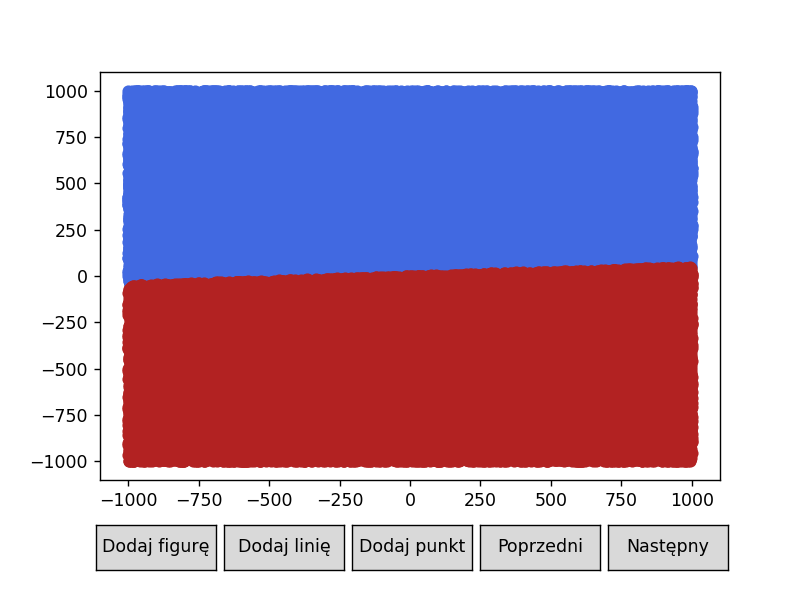

det3x3: 

Left: 		 50009 	
Right: 		 49991 	
On line: 	 0 	
Time: 		 0.0688161849975586


det2x2: 

Left: 		 50009 	
Right: 		 49991 	
On line: 	 0 	
Time: 		 0.05037045478820801


det3x3numpy: 

Left: 		 50009 	
Right: 		 49991 	
On line: 	 0 	
Time: 		 1.0781431198120117


det2x2numpy: 

Left: 		 50009 	
Right: 		 49991 	
On line: 	 0 	
Time: 		 0.9659216403961182


In [16]:
analize_figure(T1, 10**-8)

<IPython.core.display.Javascript object>


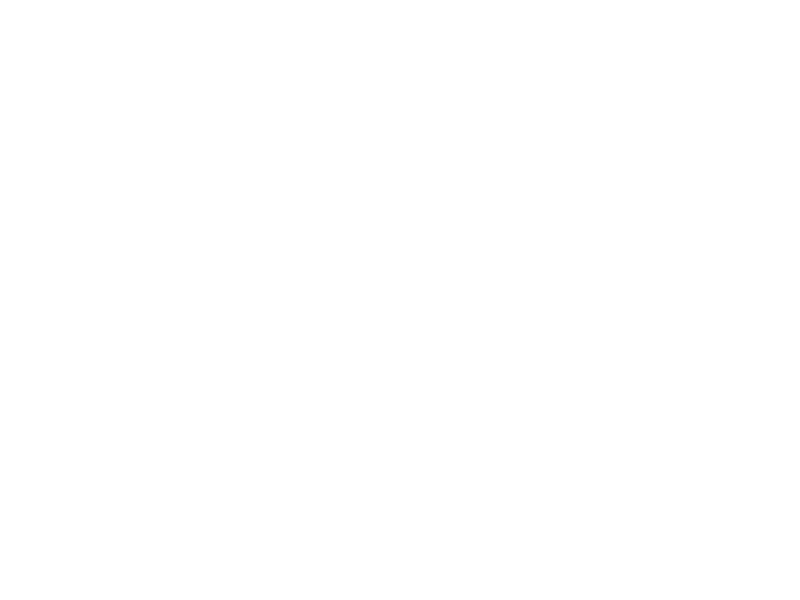

det3x3: 

Left: 		 49775 	
Right: 		 50225 	
On line: 	 0 	
Time: 		 0.06781840324401855


det2x2: 

Left: 		 49775 	
Right: 		 50218 	
On line: 	 7 	
Time: 		 0.049866676330566406


det3x3numpy: 

Left: 		 49775 	
Right: 		 50225 	
On line: 	 0 	
Time: 		 1.091721773147583


det2x2numpy: 

Left: 		 49773 	
Right: 		 50218 	
On line: 	 9 	
Time: 		 0.9724781513214111


In [17]:
analize_figure(T2, 10**-8)

<IPython.core.display.Javascript object>


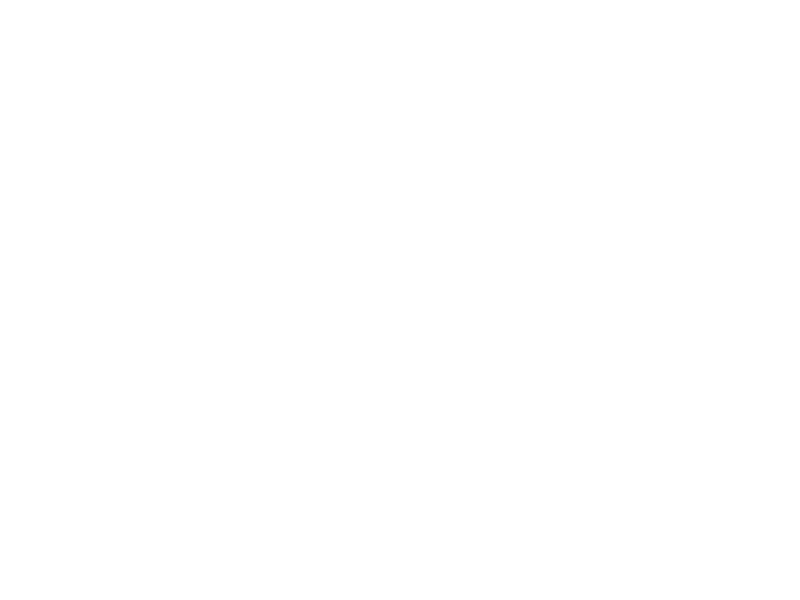

det3x3: 

Left: 		 481 	
Right: 		 519 	
On line: 	 0 	
Time: 		 0.000995635986328125


det2x2: 

Left: 		 481 	
Right: 		 519 	
On line: 	 0 	
Time: 		 0.0


det3x3numpy: 

Left: 		 481 	
Right: 		 519 	
On line: 	 0 	
Time: 		 0.010970354080200195


det2x2numpy: 

Left: 		 481 	
Right: 		 519 	
On line: 	 0 	
Time: 		 0.009973764419555664


In [22]:
analize_figure(circle, 10**-18)

<IPython.core.display.Javascript object>


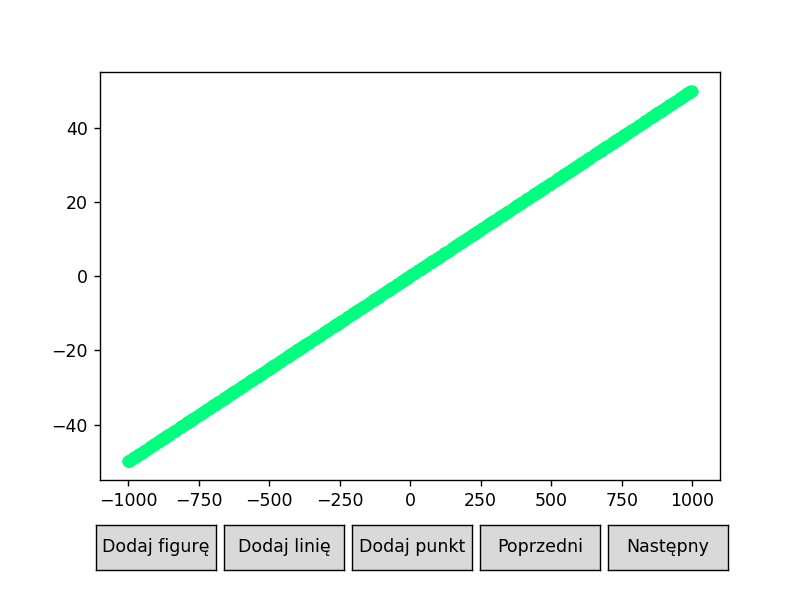

det3x3: 

Left: 		 0 	
Right: 		 0 	
On line: 	 1000 	
Time: 		 0.0009975433349609375


det2x2: 

Left: 		 170 	
Right: 		 141 	
On line: 	 689 	
Time: 		 0.0009975433349609375


det3x3numpy: 

Left: 		 18 	
Right: 		 98 	
On line: 	 884 	
Time: 		 0.012964725494384766


det2x2numpy: 

Left: 		 157 	
Right: 		 146 	
On line: 	 697 	
Time: 		 0.011967897415161133


In [26]:
analize_figure(line, 10**-14)

In [27]:
# Porównuje ze sobą dwa zbiory i zapisuje części wspólne, nie wspólne zakfalifikowane do linii oraz nie zakwalifikowane
# przez żadną funkcję.
# Przyjmuje na wejściu zbiór punktów który chcemy użyć, dla jakiego wyznacznika i tolerancji chcemy porównać wykresy

def compare(T, det1, det2, tol1, tol2):
    l1, m1, r1 = group(T, det1, tol1)
    l2, m2, r2 = group(T, det2, tol2)
    
    points1 = []
    for i in l1:
        points1.append((i, 0))
    for i in m1:
        points1.append((i, 1))
    for i in r1:
        points1.append((i, 2))
        
    points2 = []
    for i in l2:
        points2.append((i, 0))
    for i in m2:
        points2.append((i, 1))
    for i in r2:
        points2.append((i, 2))
        
    points1.sort()
    points2.sort()
    
    common = []
    uncommon = []
    non = []
    for i in range(len(points1)):
        if points1[i] != points2[i]:
            uncommon.append((points1[i], points2[i]))
        elif points1[i][1] == 1:
            common.append(points1[i][0])
        else: 
            non.append(points1[i][0])
    

    print('A: \t', len(m1))
    print('B: \t', len(m2))
    print('Common: \t', len(common))
    print('Uncommon: \t', len(uncommon))
    print('None: \t', len(points1) - len(common) - len(uncommon))
    
    return uncommon, non, common

In [28]:
# Wypisuje punkty, które różnie zostały zakwalifikowane do prostej

def print_difference(T, det1, det2, tol1, tol2):
    uncommon, non, common = compare(T, det1, det2, tol1, tol2)
    mid1 = []
    mid2 = []
    for i in uncommon:
        if i[0][1] == 1:
            mid1.append(i[0][0])
        else:
            mid2.append(i[0][0])
    
    
    plot = Plot(points=[PointsCollection(non, color = 'white'),PointsCollection(mid1, color = 'royalblue'),
               PointsCollection(mid2, color = 'firebrick')])
    
    plot.draw()
                        
    print('Blue - classified in case 1\nRed - classified in case 2')

In [29]:
# Wypisuje punkty które wspólnie zostały zakwalifikowane do prostej

def print_common(T, det1, det2, tol1, tol2):
    common = compare(T, det1, det2, tol1, tol2)[2]
    plot = Plot(points=[PointsCollection(common, color = 'firebrick')])
    plot.draw()

A: 	 427
B: 	 679
Common: 	 244
Uncommon: 	 691
None: 	 65


<IPython.core.display.Javascript object>


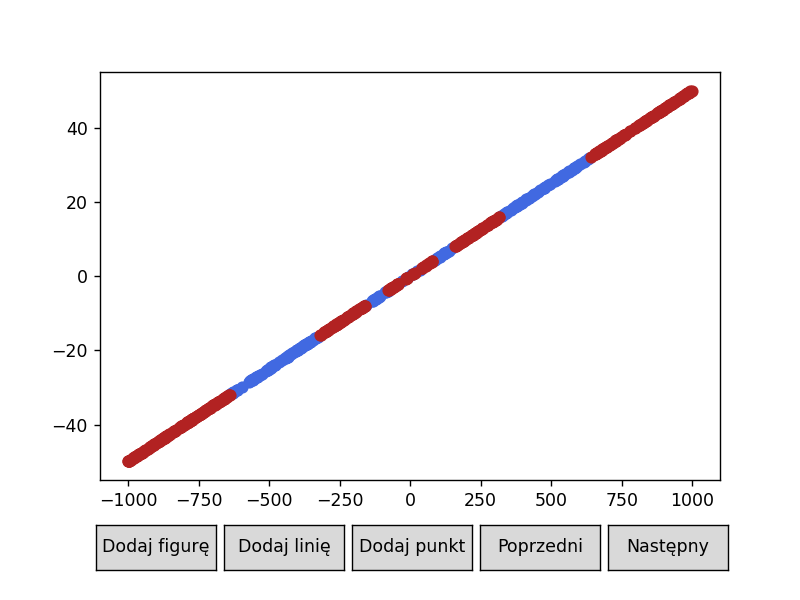

Blue - classified in case 1
Red - classified in case 2


In [30]:
print_difference(line, det1, det2, 10**-16, 10**-16)

A: 	 427
B: 	 679
Common: 	 244
Uncommon: 	 691
None: 	 65


<IPython.core.display.Javascript object>


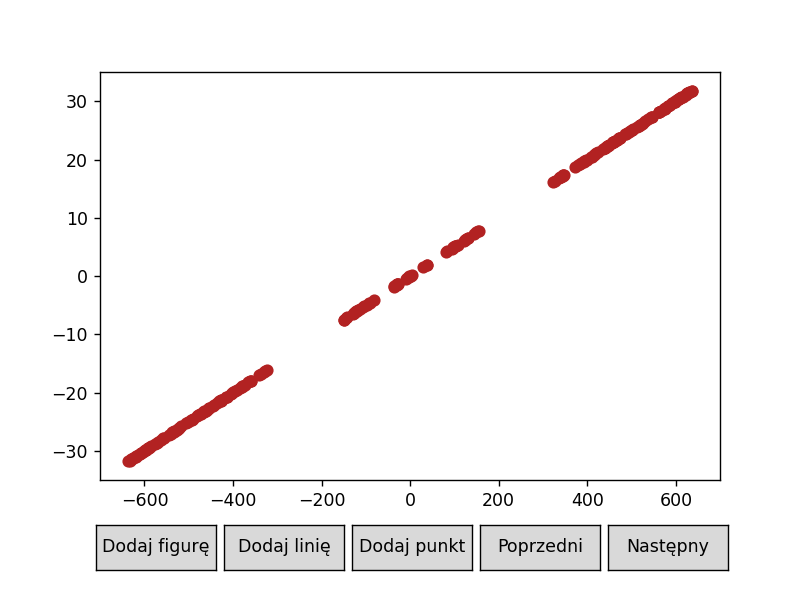

In [31]:
print_common(line, det1, det2, 10**-16, 10**-16)

<IPython.core.display.Javascript object>


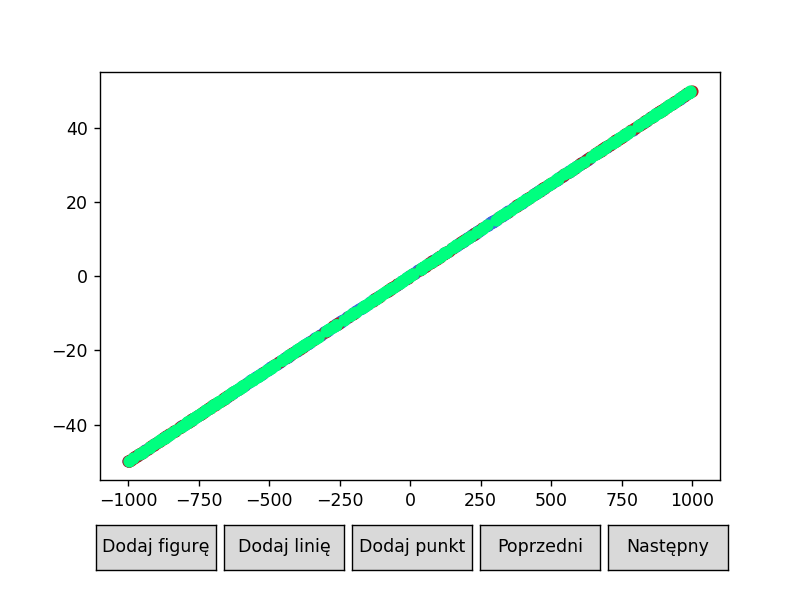

In [32]:
    draw_graph(line, det3, 10**-18)